In [ ]:
# Link to shared Google Drive
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

SHARED_DRIVE = Path("/content/drive/Shareddrives/Natural Language Processing")
assert SHARED_DRIVE.exists(), "Shared Google Drive not found"

Mounted at /content/drive


# Code Masking Utility

In [ ]:
import ast
import random
import builtins
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Optional
from copy import deepcopy


class MaskStrategy(Enum):
    ALL = auto() # Mask all identifiers
    RANDOM = auto() # Mask random subset of identifiers
    SINGLE = auto() # Mask one identifier at a time (returns multiple samples)


@dataclass
class MaskConfig:
    mask_token: str = "<mask>"
    mask_variables: bool = True
    mask_functions: bool = True
    mask_classes: bool = True
    preserve_builtins: bool = True
    preserve_imports: bool = True
    preserve_self: bool = True
    preserve_first_identifier: bool = True
    strategy: MaskStrategy = MaskStrategy.ALL
    random_mask_probability: float = 0.5  # For RANDOM strategy
    random_seed: Optional[int] = None

    # Preset configurations
    @classmethod
    def for_bert(cls) -> 'MaskConfig':
        return cls(mask_token="<mask>")

    @classmethod
    def for_valid_python(cls) -> 'MaskConfig':
        return cls(mask_token="MASK")


@dataclass
class MaskedCodeResult:
    original_code: str
    masked_code: str
    masked_identifiers: list = field(default_factory=list)
    mask_count: int = 0

    def __repr__(self):
        return (f"MaskedCodeResult(mask_count={self.mask_count}, "
                f"identifiers={self.masked_identifiers})")


class IdentifierCollector(ast.NodeVisitor):
    """Collects all identifier names and their locations in the AST."""

    def __init__(self, config: MaskConfig):
        self.config = config
        self.identifiers: list[dict] = []
        self.builtin_names = set(dir(builtins))
        self.imported_names: set[str] = set()
        self._current_scope: list[str] = []
        self.first_identifier_seen = False

    def visit_Import(self, node: ast.Import):
        """Track imported module names."""
        for alias in node.names:
            name = alias.asname if alias.asname else alias.name.split('.')[0]
            self.imported_names.add(name)
        self.generic_visit(node)

    def visit_ImportFrom(self, node: ast.ImportFrom):
        """Track names imported from modules."""
        for alias in node.names:
            name = alias.asname if alias.asname else alias.name
            self.imported_names.add(name)
        self.generic_visit(node)

    def visit_Name(self, node: ast.Name):
        """Collect variable names."""
        if self.config.mask_variables:
            if not self._should_preserve(node.id):
                self.identifiers.append({
                    'type': 'variable',
                    'name': node.id,
                    'node': node,
                    'lineno': node.lineno,
                    'col_offset': node.col_offset
                })
        self.generic_visit(node)

    def visit_FunctionDef(self, node: ast.FunctionDef):
        """Collect function names."""
        if self.config.mask_functions:
            if not self._should_preserve(node.name):
                self.identifiers.append({
                    'type': 'function',
                    'name': node.name,
                    'node': node,
                    'lineno': node.lineno,
                    'col_offset': node.col_offset
                })
        self._current_scope.append(node.name)
        self.generic_visit(node)
        self._current_scope.pop()

    def visit_AsyncFunctionDef(self, node: ast.AsyncFunctionDef):
        """Collect async function names."""
        if self.config.mask_functions:
            if not self._should_preserve(node.name):
                self.identifiers.append({
                    'type': 'async_function',
                    'name': node.name,
                    'node': node,
                    'lineno': node.lineno,
                    'col_offset': node.col_offset
                })
        self._current_scope.append(node.name)
        self.generic_visit(node)
        self._current_scope.pop()

    def visit_ClassDef(self, node: ast.ClassDef):
        """Collect class names."""
        if self.config.mask_classes:
            if not self._should_preserve(node.name):
                self.identifiers.append({
                    'type': 'class',
                    'name': node.name,
                    'node': node,
                    'lineno': node.lineno,
                    'col_offset': node.col_offset
                })
        self._current_scope.append(node.name)
        self.generic_visit(node)
        self._current_scope.pop()

    def _should_preserve(self, name: str) -> bool:
        """Check if a name should be preserved (not masked)."""
        if self.config.preserve_builtins and name in self.builtin_names:
            return True
        if self.config.preserve_imports and name in self.imported_names:
            return True
        if self.config.preserve_self and name in ('self', 'cls'):
            return True
        # Preserve dunder methods and private markers
        if name.startswith('__') and name.endswith('__'):
            return True
        if self.config.preserve_first_identifier and not self.first_identifier_seen:
            self.first_identifier_seen = True
            return True

        return False


class SelectiveMasker(ast.NodeTransformer):
    """Masks only selected identifiers in the AST."""

    def __init__(self, config: MaskConfig, identifiers_to_mask: set[str]):
        self.config = config
        self.identifiers_to_mask = identifiers_to_mask
        self.masked_count = 0

    def visit_Name(self, node: ast.Name):
        """Mask variable names if selected."""
        self.generic_visit(node)
        if node.id in self.identifiers_to_mask:
            self.masked_count += 1
            return ast.copy_location(
                ast.Name(id=self.config.mask_token, ctx=node.ctx),
                node
            )
        return node

    def visit_FunctionDef(self, node: ast.FunctionDef):
        """Mask function names if selected."""
        self.generic_visit(node)
        new_name = node.name
        if node.name in self.identifiers_to_mask:
            new_name = self.config.mask_token
            self.masked_count += 1

        return ast.copy_location(
            ast.FunctionDef(
                name=new_name,
                args=node.args,
                body=node.body,
                decorator_list=node.decorator_list,
                returns=node.returns,
                type_comment=getattr(node, 'type_comment', None),
                type_params=getattr(node, 'type_params', [])
            ),
            node
        )

    def visit_AsyncFunctionDef(self, node: ast.AsyncFunctionDef):
        """Mask async function names if selected."""
        self.generic_visit(node)
        new_name = node.name
        if node.name in self.identifiers_to_mask:
            new_name = self.config.mask_token
            self.masked_count += 1

        return ast.copy_location(
            ast.AsyncFunctionDef(
                name=new_name,
                args=node.args,
                body=node.body,
                decorator_list=node.decorator_list,
                returns=node.returns,
                type_comment=getattr(node, 'type_comment', None),
                type_params=getattr(node, 'type_params', [])
            ),
            node
        )

    def visit_ClassDef(self, node: ast.ClassDef):
        """Mask class names if selected."""
        self.generic_visit(node)
        new_name = node.name
        if node.name in self.identifiers_to_mask:
            new_name = self.config.mask_token
            self.masked_count += 1

        return ast.copy_location(
            ast.ClassDef(
                name=new_name,
                bases=node.bases,
                keywords=node.keywords,
                body=node.body,
                decorator_list=node.decorator_list,
                type_params=getattr(node, 'type_params', [])
            ),
            node
        )


def mask_code(
    code_block: str,
    config: Optional[MaskConfig] = None
) -> MaskedCodeResult | list[MaskedCodeResult]:

    if config is None:
        config = MaskConfig()

    if config.random_seed is not None:
        random.seed(config.random_seed)

    # Parse the code
    tree = ast.parse(code_block)

    # Collect all identifiers
    collector = IdentifierCollector(config)
    collector.visit(tree)

    # Get unique identifier names
    all_identifiers = list({item['name'] for item in collector.identifiers})

    if not all_identifiers:
        return MaskedCodeResult(
            original_code=code_block,
            masked_code=code_block,
            masked_identifiers=[],
            mask_count=0
        )

    # Apply masking based on strategy
    if config.strategy == MaskStrategy.ALL:
        return _mask_all(code_block, tree, config, all_identifiers)

    elif config.strategy == MaskStrategy.RANDOM:
        selected = [
            name for name in all_identifiers
            if random.random() < config.random_mask_probability
        ]
        # Ensure at least one is masked if there are identifiers
        if not selected and all_identifiers:
            selected = [random.choice(all_identifiers)]
        return _mask_all(code_block, tree, config, selected)

    elif config.strategy == MaskStrategy.SINGLE:
        results = []
        for identifier in all_identifiers:
            # Create fresh tree for each masking
            fresh_tree = ast.parse(code_block)
            result = _mask_all(code_block, fresh_tree, config, [identifier])
            results.append(result)
        return results

    else:
        raise ValueError(f"Unknown masking strategy: {config.strategy}")


def _mask_all(
    original_code: str,
    tree: ast.AST,
    config: MaskConfig,
    identifiers_to_mask: list[str]
) -> MaskedCodeResult:
    """Apply masking to selected identifiers."""
    identifiers_set = set(identifiers_to_mask)

    masker = SelectiveMasker(config, identifiers_set)
    masked_tree = masker.visit(tree)
    ast.fix_missing_locations(masked_tree)

    masked_code = ast.unparse(masked_tree)

    return MaskedCodeResult(
        original_code=original_code,
        masked_code=masked_code,
        masked_identifiers=identifiers_to_mask,
        mask_count=masker.masked_count
    )


def create_training_pairs(
    code_block: str,
    config: Optional[MaskConfig] = None
) -> list[tuple[str, str, list[str]]]:

    if config is None:
        config = MaskConfig(strategy=MaskStrategy.SINGLE)

    result = mask_code(code_block, config)

    if isinstance(result, list):
        return [
            (r.masked_code, r.original_code, r.masked_identifiers)
            for r in result
        ]
    else:
        return [(result.masked_code, result.original_code, result.masked_identifiers)]

In [ ]:
## Code masking test

example_code = """
def fizzbuzz(n):
  for i in range(1, n + 1):
    if i % 3 == 0 and i % 5 == 0:
      print("FizzBuzz")
    elif i % 3 == 0:
      print("Fizz")
    elif i % 5 == 0:
      print("Buzz")
"""

mask_config = MaskConfig() # Default settings
result = mask_code(example_code, mask_config)
print(result)
print()
print(result.masked_code)

MaskedCodeResult(mask_count=6, identifiers=['i', 'n'])

def fizzbuzz(n):
    for <mask> in range(1, <mask> + 1):
        if <mask> % 3 == 0 and <mask> % 5 == 0:
            print('FizzBuzz')
        elif <mask> % 3 == 0:
            print('Fizz')
        elif <mask> % 5 == 0:
            print('Buzz')


# Evaluation Framework

In [ ]:

import ast
import subprocess
import tempfile
import os
import json
import hashlib
import re
from dataclasses import dataclass, field
from typing import Optional, Callable
from enum import Enum, auto
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, TimeoutError as FuturesTimeoutError
import traceback


@dataclass
class SingleEvalResult:
    """Result for a single code sample evaluation."""
    task_id: str
    original_code: str
    masked_code: str
    predicted_code: str
    masked_identifiers: list[str]

    # Metric results
    syntax_valid: bool = False
    syntax_error: Optional[str] = None

    tests_passed: bool = False
    tests_error: Optional[str] = None
    tests_output: Optional[str] = None

    exact_match: bool = False

    # Additional metrics
    identifier_accuracy: float = 0.0  # Percent of correct identifiers
    predicted_identifiers: list[str] = field(default_factory=list)

    def to_dict(self) -> dict:
        return {
            'task_id': self.task_id,
            'syntax_valid': self.syntax_valid,
            'tests_passed': self.tests_passed,
            'exact_match': self.exact_match,
            'identifier_accuracy': self.identifier_accuracy,
            'syntax_error': self.syntax_error,
            'tests_error': self.tests_error,
        }


@dataclass
class EvaluationSummary:
    """Aggregated evaluation results across all samples."""
    total_samples: int = 0

    # Counts
    syntax_valid_count: int = 0
    tests_passed_count: int = 0
    exact_match_count: int = 0

    # Rates
    syntax_valid_rate: float = 0.0
    tests_passed_rate: float = 0.0
    exact_match_rate: float = 0.0

    # Additional metrics
    mean_identifier_accuracy: float = 0.0

    # Detailed results
    results: list[SingleEvalResult] = field(default_factory=list)

    # Errors
    execution_errors: int = 0
    timeout_errors: int = 0

    def compute_rates(self):
        """Compute rates from counts."""
        if self.total_samples > 0:
            self.syntax_valid_rate = self.syntax_valid_count / self.total_samples
            self.tests_passed_rate = self.tests_passed_count / self.total_samples
            self.exact_match_rate = self.exact_match_count / self.total_samples

            accuracies = [r.identifier_accuracy for r in self.results]
            self.mean_identifier_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0

    def to_dict(self) -> dict:
        return {
            'total_samples': self.total_samples,
            'syntax_valid': {
                'count': self.syntax_valid_count,
                'rate': round(self.syntax_valid_rate, 4)
            },
            'tests_passed': {
                'count': self.tests_passed_count,
                'rate': round(self.tests_passed_rate, 4)
            },
            'exact_match': {
                'count': self.exact_match_count,
                'rate': round(self.exact_match_rate, 4)
            },
            'mean_identifier_accuracy': round(self.mean_identifier_accuracy, 4),
            'errors': {
                'execution': self.execution_errors,
                'timeout': self.timeout_errors
            }
        }

    def print_summary(self):
        """Print a formatted summary of results."""
        print("\n" + "=" * 60)
        print("EVALUATION SUMMARY")
        print("=" * 60)
        print(f"Total samples evaluated: {self.total_samples}")
        print()
        print("Metric                  Count       Rate")
        print("-" * 45)
        print(f"Syntax Valid            {self.syntax_valid_count:5d}       {self.syntax_valid_rate:.2%}")
        print(f"Tests Passed            {self.tests_passed_count:5d}       {self.tests_passed_rate:.2%}")
        print(f"Exact Match             {self.exact_match_count:5d}       {self.exact_match_rate:.2%}")
        print()
        print(f"Mean Identifier Accuracy: {self.mean_identifier_accuracy:.2%}")
        print()
        if self.execution_errors or self.timeout_errors:
            print(f"Errors: {self.execution_errors} execution, {self.timeout_errors} timeout")
        print("=" * 60)


# Metric 1: Syntax validity

def check_syntax_validity(code: str) -> tuple[bool, Optional[str]]:

    try:
        ast.parse(code)
        return True, None
    except SyntaxError as e:
        return False, f"Line {e.lineno}: {e.msg}"
    except Exception as e:
        return False, str(e)


# Metric 2: Functional Correctness (Safe Execution)

EXECUTION_TEMPLATE = '''
import sys
import signal

# Timeout handler
def timeout_handler(signum, frame):
    raise TimeoutError("Execution timed out")

# Set timeout
signal.signal(signal.SIGALRM, timeout_handler)
signal.alarm({timeout})

# Import common modules that tests might need
import math
import re
import collections
from collections import defaultdict, Counter, OrderedDict, deque
import itertools
import functools
import operator
import string
import heapq
import bisect
import copy

# Setup code (if any)
{setup_code}

# The code being tested
{code}

# Run the tests inside try block
try:
{test_code}
    print("__TESTS_PASSED__")
except AssertionError as e:
    print(f"__ASSERTION_ERROR__: {{e}}")
    sys.exit(1)
except TimeoutError as e:
    print(f"__TIMEOUT_ERROR__: {{e}}")
    sys.exit(2)
except Exception as e:
    print(f"__EXECUTION_ERROR__: {{type(e).__name__}}: {{e}}")
    sys.exit(1)
finally:
    signal.alarm(0)
'''


def run_code_safely(
    code: str,
    test_code: str,
    setup_code: str = "",
    timeout: int = 5
) -> tuple[bool, Optional[str], Optional[str]]:

    # Indent all test code lines uniformly for the try block
    indented_test_code = "\n".join(
        "    " + line for line in test_code.split("\n")
    )

    # Prepare the full execution script
    full_script = EXECUTION_TEMPLATE.format(
        timeout=timeout,
        setup_code=setup_code,
        code=code,
        test_code=indented_test_code
    )

    # Create a temporary file
    with tempfile.NamedTemporaryFile(
        mode='w',
        suffix='.py',
        delete=False
    ) as f:
        f.write(full_script)
        temp_path = f.name

    try:
        # Run in subprocess with additional timeout safety
        result = subprocess.run(
            ['python3', temp_path],
            capture_output=True,
            text=True,
            timeout=timeout + 2  # Extra buffer for subprocess overhead
        )

        stdout = result.stdout
        stderr = result.stderr

        # Check for success marker
        if "__TESTS_PASSED__" in stdout:
            return True, None, stdout

        # Parse error type
        if "__ASSERTION_ERROR__" in stdout:
            error_msg = stdout.split("__ASSERTION_ERROR__:")[-1].strip()
            return False, f"Assertion failed: {error_msg}", stdout

        if "__TIMEOUT_ERROR__" in stdout:
            return False, "Execution timed out", stdout

        if "__EXECUTION_ERROR__" in stdout:
            error_msg = stdout.split("__EXECUTION_ERROR__:")[-1].strip()
            return False, f"Execution error: {error_msg}", stdout

        # Generic failure
        return False, stderr or "Unknown error", stdout + stderr

    except subprocess.TimeoutExpired:
        return False, "Subprocess timed out", None
    except Exception as e:
        return False, f"Subprocess error: {e}", None
    finally:
        # Clean up temp file
        try:
            os.unlink(temp_path)
        except:
            pass


def format_tests_for_execution(test_list: list[str]) -> str:
    """Simply put assersions on new lines"""
    return "\n".join(test_list)


# Metric 3: Exact Match

def normalize_code(code: str) -> str:

    try:
        tree = ast.parse(code)
        return ast.unparse(tree)
    except SyntaxError:
        # If it doesn't parse, return stripped version
        return code.strip()


def check_exact_match(predicted: str, original: str) -> bool:

    return normalize_code(predicted) == normalize_code(original)


# Metric 4: Identifier Accuracy

def extract_identifiers(code: str) -> set[str]:

    try:
        tree = ast.parse(code)
    except SyntaxError:
        return set()

    identifiers = set()

    for node in ast.walk(tree):
        if isinstance(node, ast.Name):
            identifiers.add(node.id)
        elif isinstance(node, ast.FunctionDef):
            identifiers.add(node.name)
        elif isinstance(node, ast.AsyncFunctionDef):
            identifiers.add(node.name)
        elif isinstance(node, ast.ClassDef):
            identifiers.add(node.name)

    return identifiers


def compute_identifier_accuracy(
    predicted: str,
    original: str,
    masked_identifiers: list[str]
) -> tuple[float, list[str]]:
    """
    Compute what fraction of masked identifiers were correctly predicted.

    This is a softer metric than exact match - it checks if the model
    predicted the right identifier names even if placement differs slightly.
    """
    original_ids = extract_identifiers(original)
    predicted_ids = extract_identifiers(predicted)

    # Get the identifiers that were in original but masked
    masked_set = set(masked_identifiers)

    # Check how many masked identifiers appear in prediction
    # This is approximate - in reality we'd need position matching
    correct = 0
    for ident in masked_identifiers:
        if ident in predicted_ids:
            correct += 1

    accuracy = correct / len(masked_identifiers) if masked_identifiers else 1.0

    return accuracy, list(predicted_ids)


# Main Evaluator Class

class CodeEvaluator:

    def __init__(
        self,
        timeout: int = 5,
        run_tests: bool = True,
        verbose: bool = False
    ):

        self.timeout = timeout
        self.run_tests = run_tests
        self.verbose = verbose


    def evaluate_single(
        self,
        task_id: str,
        original_code: str,
        masked_code: str,
        predicted_code: str,
        test_code: str = "",
        setup_code: str = "",
        masked_identifiers: list[str] = None
    ) -> SingleEvalResult:

        if masked_identifiers is None:
            masked_identifiers = []

        result = SingleEvalResult(
            task_id=task_id,
            original_code=original_code,
            masked_code=masked_code,
            predicted_code=predicted_code,
            masked_identifiers=masked_identifiers
        )

        # Metric 1: Syntax Validity
        result.syntax_valid, result.syntax_error = check_syntax_validity(predicted_code)

        if self.verbose:
            status = "SUCCESS" if result.syntax_valid else "FAILURE"
            print(f"  [{task_id}] Syntax: {status}")

        # Metric 2: Functional Correctness (only if syntax valid and tests provided)
        if result.syntax_valid and self.run_tests and test_code:
            result.tests_passed, result.tests_error, result.tests_output = run_code_safely(
                code=predicted_code,
                test_code=test_code,
                setup_code=setup_code,
                timeout=self.timeout
            )

            if self.verbose:
                status = "SUCCESS" if result.tests_passed else "FAILURE"
                print(f"  [{task_id}] Tests: {status}")
        elif not test_code:
            result.tests_error = "No tests provided"
        elif not result.syntax_valid:
            result.tests_error = "Skipped due to syntax error"

        # Metric 3: Exact Match
        result.exact_match = check_exact_match(predicted_code, original_code)

        if self.verbose:
            status = "SUCCESS" if result.exact_match else "FAILURE"
            print(f"  [{task_id}] Exact Match: {status}")

        # Metric 4: Identifier Accuracy
        if result.syntax_valid and masked_identifiers:
            result.identifier_accuracy, result.predicted_identifiers = compute_identifier_accuracy(
                predicted_code, original_code, masked_identifiers
            )

        return result

    def evaluate_batch(
        self,
        samples: list[dict],
        max_workers: int = 1
    ) -> EvaluationSummary:

        summary = EvaluationSummary()
        summary.total_samples = len(samples)

        if self.verbose:
            print(f"\nEvaluating {len(samples)} samples...")

        for i, sample in enumerate(samples):
            if self.verbose and (i + 1) % 10 == 0:
                print(f"Progress: {i + 1}/{len(samples)}")

            try:
                result = self.evaluate_single(
                    task_id=sample.get('task_id', f'sample_{i}'),
                    original_code=sample['original_code'],
                    masked_code=sample['masked_code'],
                    predicted_code=sample['predicted_code'],
                    test_code=sample.get('test_code', ''),
                    setup_code=sample.get('setup_code', ''),
                    masked_identifiers=sample.get('masked_identifiers', [])
                )

                summary.results.append(result)

                if result.syntax_valid:
                    summary.syntax_valid_count += 1
                if result.tests_passed:
                    summary.tests_passed_count += 1
                if result.exact_match:
                    summary.exact_match_count += 1

            except Exception as e:
                summary.execution_errors += 1
                if self.verbose:
                    print(f"  Error evaluating sample {i}: {e}")

        summary.compute_rates()
        return summary

    def save_results(self, summary: EvaluationSummary, path: str):
        """Save results in JSON format"""

        output = {
            'summary': summary.to_dict(),
            'detailed_results': [r.to_dict() for r in summary.results]
        }

        with open(path, 'w') as f:
            json.dump(output, f, indent=2)

        if self.verbose:
            print(f"Results saved to {path}")


# Pass@k Evaluation

def pass_at_k(n: int, c: int, k: int) -> float:
    """
    Calculate pass@k metric.

    Estimates the probability that at least one of k samples passes,
    given n total samples with c correct.

    Args:
        n: Total number of samples generated
        c: Number of correct samples
        k: Number of samples to consider

    Returns:
        pass@k probability
    """
    if n - c < k:
        return 1.0

    # Calculate using the formula: 1 - C(n-c, k) / C(n, k)
    # Which simplifies to: 1 - prod((n-c-i)/(n-i) for i in range(k))
    result = 1.0
    for i in range(k):
        result *= (n - c - i) / (n - i)

    return 1.0 - result


def evaluate_pass_at_k(
    evaluator: CodeEvaluator,
    task_samples: dict[str, list[dict]],
    k_values: list[int] = [1, 5, 10]
) -> dict:
    """
    Evaluate pass@k for multiple k values.

    Args:
        evaluator: CodeEvaluator instance
        task_samples: Dict mapping task_id to list of sample predictions
        k_values: List of k values to compute

    Returns:
        Dict with pass@k results
    """
    results = {f'pass@{k}': [] for k in k_values}

    for task_id, samples in task_samples.items():
        # Evaluate all samples for this task
        n = len(samples)
        c = 0  # Count of correct samples

        for sample in samples:
            result = evaluator.evaluate_single(
                task_id=task_id,
                **sample
            )
            if result.tests_passed:
                c += 1

        # Compute pass@k for each k
        for k in k_values:
            if k <= n:
                results[f'pass@{k}'].append(pass_at_k(n, c, k))

    # Average across tasks
    return {
        metric: sum(values) / len(values) if values else 0.0
        for metric, values in results.items()
    }

# Dataset Loaders (MBPP and HumanEval)

In [ ]:
import json
import re
from dataclasses import dataclass
from typing import Optional, Iterator
from pathlib import Path

from datasets import load_dataset


# Data Classes

@dataclass
class CodeSample:
    """A single code sample ready for evaluation."""
    task_id: str
    description: str
    code: str
    test_code: str
    setup_code: str = ""

    # For tracking after masking
    masked_code: Optional[str] = None
    masked_identifiers: Optional[list[str]] = None

    def to_eval_dict(self, predicted_code: str) -> dict:
        """Convert to dict format expected by CodeEvaluator."""
        return {
            'task_id': self.task_id,
            'original_code': self.code,
            'masked_code': self.masked_code or "",
            'predicted_code': predicted_code,
            'test_code': self.test_code,
            'setup_code': self.setup_code,
            'masked_identifiers': self.masked_identifiers or []
        }


# =============================================================================
# MBPP Loader
# =============================================================================

class MBPPLoader:

    DATASET_NAME = "mbpp"

    # Official split boundaries
    FEW_SHOT_IDS = range(1, 11)      # 1-10
    TEST_IDS = range(11, 511)         # 11-510
    VALIDATION_IDS = range(511, 601)  # 511-600
    TRAIN_IDS = range(601, 975)       # 601-974

    def __init__(self, use_sanitized: bool = False, local_path: str = None):

        self.use_sanitized = use_sanitized
        self.local_path = local_path
        self._dataset = None
        self._local_data = None

    def _load_from_local(self, path: str) -> list[dict]:
        """Load data from local JSONL file."""
        data = []
        with open(path, 'r') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
        return data

    def _load_dataset(self):
        """Load the dataset from HuggingFace or local file."""

        # For some reason, HuggingFace datasets does not provide the full MBPP set
        # so default to local file if available
        if self.local_path:
            if self._local_data is None:
                self._local_data = self._load_from_local(self.local_path)
            return None

        if self._dataset is None:
            try:
                if self.use_sanitized:
                    self._dataset = load_dataset("mbpp", "sanitized")
                else:
                    self._dataset = load_dataset("mbpp")
            except Exception as e:
                raise RuntimeError(
                    f"Could not load from HuggingFace: {e}\n"
                    "Please download the dataset manually:\n"
                    "  wget https://raw.githubusercontent.com/google-research/google-research/master/mbpp/mbpp.jsonl\n"
                    "Then use: MBPPLoader(local_path='mbpp.jsonl')"
                )

        return self._dataset

    def load_and_prepare(
        self,
        split: str = 'test',
        limit: Optional[int] = None,
        task_ids: Optional[list[int]] = None
    ) -> list[CodeSample]:

        dataset = self._load_dataset()

        # Determine data source
        if self._local_data is not None:
            data = self._local_data
        elif self.use_sanitized:
            data = dataset['test']
        else:
            data = dataset['test']

        samples = []

        for item in data:
            task_id = item['task_id']

            # Filter by split or specific IDs
            if task_ids is not None:
                if task_id not in task_ids:
                    continue
            elif split != 'all':
                if split == 'train' and task_id not in self.TRAIN_IDS:
                    continue
                elif split == 'test' and task_id not in self.TEST_IDS:
                    continue
                elif split == 'validation' and task_id not in self.VALIDATION_IDS:
                    continue
                elif split == 'few_shot' and task_id not in self.FEW_SHOT_IDS:
                    continue

            # Extract fields based on dataset version
            if self.use_sanitized and not self._local_data:
                description = item.get('prompt', '')
                test_list = item.get('test_list', [])
                setup_code = "\n".join(item.get('test_imports', []))
            else:
                description = item.get('text', '')
                test_list = item.get('test_list', [])
                setup_code = item.get('test_setup_code', '') or ''

            # Format test code
            test_code = "\n".join(test_list)

            sample = CodeSample(
                task_id=str(task_id),
                description=description,
                code=item['code'],
                test_code=test_code,
                setup_code=setup_code
            )

            samples.append(sample)

            if limit and len(samples) >= limit:
                break

        return samples

    def get_split_sizes(self) -> dict:
        """Get the size of each split."""
        return {
            'few_shot': len(self.FEW_SHOT_IDS),
            'test': len(self.TEST_IDS),
            'validation': len(self.VALIDATION_IDS),
            'train': len(self.TRAIN_IDS),
            'total': 974
        }


# HumanEval Loader

class HumanEvalLoader:

    DATASET_NAME = "openai_humaneval"

    def __init__(self):
        """Initialize the HumanEval loader."""
        self._dataset = None

    def _load_dataset(self):
        """Load the dataset from HuggingFace."""

        if self._dataset is None:
            self._dataset = load_dataset("openai_humaneval", trust_remote_code=True)

        return self._dataset

    def load_and_prepare(
        self,
        limit: Optional[int] = None,
        task_ids: Optional[list[str]] = None
    ) -> list[CodeSample]:

        dataset = self._load_dataset()
        data = dataset['test']

        samples = []

        for item in data:
            task_id = item['task_id']

            # Filter by specific IDs if provided
            if task_ids is not None and task_id not in task_ids:
                continue

            # Combine prompt and solution to get full code
            prompt = item['prompt']
            solution = item['canonical_solution']
            full_code = prompt + solution

            # Extract docstring as description
            description = self._extract_docstring(prompt)

            # Format test code - HumanEval tests call check(candidate)
            # where candidate is the function being tested
            entry_point = item['entry_point']
            test_code = item['test']

            # The test code defines a check function, we need to call it
            # with the actual function as the candidate
            test_wrapper = f"{test_code}\ncheck({entry_point})"

            sample = CodeSample(
                task_id=task_id,
                description=description,
                code=full_code,
                test_code=test_wrapper,
                setup_code=""
            )

            samples.append(sample)

            if limit and len(samples) >= limit:
                break

        return samples

    def _extract_docstring(self, prompt: str) -> str:
        """Extract the docstring from a function prompt."""
        # Look for triple-quoted strings
        patterns = [
            r'"""(.*?)"""',
            r"'''(.*?)'''"
        ]

        for pattern in patterns:
            match = re.search(pattern, prompt, re.DOTALL)
            if match:
                return match.group(1).strip()

        return prompt.strip()

    def get_split_sizes(self) -> dict:
        """Get the size of each split."""
        return {
            'test': 164,
            'total': 164
        }


# Utility Functions

def apply_masking_to_samples(
    samples: list[CodeSample],
    masker_config = None
) -> list[CodeSample]:

    # Import masker here to avoid circular imports

    if masker_config is None:
        masker_config = MaskConfig()

    masked_samples = []

    for sample in samples:
        try:
            result = mask_code(sample.code, masker_config)

            # Handle single result (ALL or RANDOM strategy)
            if not isinstance(result, list):
                sample.masked_code = result.masked_code
                sample.masked_identifiers = result.masked_identifiers
                masked_samples.append(sample)
            else:
                # Handle multiple results (SINGLE strategy) - take first one
                # Or you could expand to multiple samples
                if result:
                    sample.masked_code = result[0].masked_code
                    sample.masked_identifiers = result[0].masked_identifiers
                    masked_samples.append(sample)

        except SyntaxError as e:
            print(f"Warning: Could not parse code for task {sample.task_id}: {e}")
            continue
        except Exception as e:
            print(f"Warning: Error masking task {sample.task_id}: {e}")
            continue

    return masked_samples


def create_evaluation_samples(
    samples: list[CodeSample],
    predictor_fn
) -> list[dict]:

    eval_samples = []

    for sample in samples:
        if sample.masked_code is None:
            print(f"Warning: Sample {sample.task_id} has no masked code, skipping")
            continue

        try:
            predicted_code = predictor_fn(sample.masked_code)
        except Exception as e:
            print(f"Warning: Prediction failed for {sample.task_id}: {e}")
            predicted_code = sample.masked_code  # Fallback to masked code

        eval_samples.append(sample.to_eval_dict(predicted_code))

    return eval_samples

# Model Definitions

In [ ]:
from pathlib import Path
import re
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM


class ModelPredictor():

    def __init__(
        self,
        model_name:str="microsoft/codebert-base-mlm",
        device:torch.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        ) -> None:
        self.model_name = model_name
        self.device = device

        if model_name in {"microsoft/codebert-base-mlm", "microsoft/graphcodebert-base", "huggingface/CodeBERTa-small-v1"}:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForMaskedLM.from_pretrained(model_name).to(self.device)
        else:

            model_path = Path(model_name)
            if model_path.exists() and model_path.is_dir():
                self.tokenizer = AutoTokenizer.from_pretrained(model_path)
                self.model = AutoModelForMaskedLM.from_pretrained(model_path).to(self.device)
            else:
                raise ValueError(f"Model '{model_name}' not found")

    def predict(self, masked_code: str) -> str:
        inputs = self.tokenizer(masked_code, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
            predicted_ids = torch.argmax(outputs.logits, dim=-1)
            predicted_tokens = self.tokenizer.convert_ids_to_tokens(predicted_ids[0])
            predicted_code = self.tokenizer.convert_tokens_to_string(predicted_tokens)
        breakpoint()

        return predicted_code

    def predict_v2(self, masked_code: str, top_k: int=3) -> str:
        """Predict masked tokens in code, preserving newlines.
        This on *should* preserve newlines...
        """
        self.model.eval()

        # Use a placeholder to preserve whitespace during tokenization
        placeholder = "§"
        code_with_placeholder = masked_code.replace('<mask>', placeholder)

        # Use offsets to find the token containing the placeholder, even if merged
        try:
            inputs = self.tokenizer(code_with_placeholder, return_tensors='pt',
                                  truncation=True, max_length=512,
                                  return_offsets_mapping=True)
            has_offsets = True
        except NotImplementedError:
            # Fallback for tokenizers that don't support fast offsets
            inputs = self.tokenizer(code_with_placeholder, return_tensors='pt',
                                  truncation=True, max_length=512)
            has_offsets = False

        inputs = {k: v.to(self.device) for k, v in inputs.items() if k != 'offset_mapping'}
        input_ids = inputs['input_ids'][0]

        mask_token_id = self.tokenizer.mask_token_id
        mask_positions = []

        if has_offsets:
            offset_mapping = inputs['offset_mapping'][0] if 'offset_mapping' in inputs else None
            pass

        inputs = self.tokenizer(code_with_placeholder, return_tensors='pt',
                              truncation=True, max_length=512,
                              return_offsets_mapping=True)

        offset_mapping = inputs.pop('offset_mapping')[0] if 'offset_mapping' in inputs else None
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        input_ids = inputs['input_ids'][0]

        if offset_mapping is not None:
            # Find all indices of the placeholder in the string
            placeholder_indices = [m.start() for m in re.finditer(re.escape(placeholder), code_with_placeholder)]

            for i, (start, end) in enumerate(offset_mapping):
                for p_idx in placeholder_indices:
                    if start <= p_idx < end:
                        input_ids[i] = mask_token_id
                        mask_positions.append(i)
                        break
        else:
             # Try to find by ID (prone to merging issues) [fallback method]
            placeholder_ids = self.tokenizer.encode(placeholder, add_special_tokens=False)
            if placeholder_ids:
                pid = placeholder_ids[0]
                mask_positions = (input_ids == pid).nonzero(as_tuple=True)[1].tolist()
                input_ids[input_ids == pid] = mask_token_id

        # Update input_ids in the tensor dict
        inputs['input_ids'][0] = input_ids

        # Ensure we have unique sorted positions
        mask_positions = sorted(list(set(mask_positions)))

        with torch.no_grad():
            outputs = self.model(**inputs)

        logits = outputs.logits

        predictions = []
        predicted_tokens = inputs['input_ids'].clone()

        for pos in mask_positions:
            pos_logits = logits[0, pos]
            top_k_tokens = torch.topk(pos_logits, top_k)

            top_predictions = [
                {'token': self.tokenizer.decode([tid]), 'score': score.item()}
                for tid, score in zip(top_k_tokens.indices, top_k_tokens.values)
            ]
            predictions.append(top_predictions)
            predicted_tokens[0, pos] = top_k_tokens.indices[0]

        # Decode preserving newlines
        predicted_code = self.tokenizer.decode(
            predicted_tokens[0],
            skip_special_tokens=False,
            clean_up_tokenization_spaces=False
        )

        special_tokens_to_remove = [
            self.tokenizer.bos_token,
            self.tokenizer.eos_token,
            self.tokenizer.pad_token,
        ]
        for special_tok in special_tokens_to_remove:
            if special_tok:
                predicted_code = predicted_code.replace(special_tok, '')

        return predicted_code.strip()

    def predict_batch(self, masked_codes: list[str]) -> list[str]:
        return [self.predict_v2(code) for code in masked_codes]

# Full Evaluation Pipeline

In [ ]:
import json
import time
from pathlib import Path
from typing import Callable


# Pipeline Functions

def run_evaluation_pipeline(
    dataset_name: str = "mbpp",
    split: str = "test",
    limit: int = None,
    model_name: str = "microsoft/codebert-base-mlm",
    output_path: str = None,
    verbose: bool = True,
    local_data_path: str = None
) -> dict:

    start_time = time.time()

    # Step 1: Load dataset
    if verbose:
        print(f"\n{'='*60}")
        print(f"EVALUATION PIPELINE")
        print(f"{'='*60}")
        print(f"\nStep 1: Loading {dataset_name} dataset...")

    if dataset_name.lower() == "mbpp":
        loader = MBPPLoader(local_path=local_data_path)
        samples = loader.load_and_prepare(split=split, limit=limit)
    elif dataset_name.lower() == "humaneval":
        loader = HumanEvalLoader()
        samples = loader.load_and_prepare(limit=limit)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    if verbose:
        print(f"  Loaded {len(samples)} samples")

    # Step 2: Apply masking
    if verbose:
        print(f"\nStep 2: Applying masking...")

    mask_config = MaskConfig(
        mask_token="<mask>",
        strategy=MaskStrategy.ALL,
        preserve_builtins=True,
        preserve_imports=True,
        preserve_self=True,
        preserve_first_identifier=True,
    )

    masked_samples = apply_masking_to_samples(samples, mask_config)

    if verbose:
        print(f"  Masked {len(masked_samples)} samples successfully")
        if len(masked_samples) < len(samples):
            print(f"  ({len(samples) - len(masked_samples)} samples failed to mask)")

    # Step 3: Run model predictions
    if verbose:
        print(f"\nStep 3: Running predictions with {model_name}...")

    model = ModelPredictor(model_name, device=torch.device("cuda"))

    predictions = []
    for i, sample in enumerate(masked_samples):
        # breakpoint() ## DEBUG!!
        if verbose and (i + 1) % 50 == 0:
            print(f"  Progress: {i + 1}/{len(masked_samples)}")

        predicted_code = model.predict_v2(sample.masked_code)
        predictions.append({
            'task_id': sample.task_id,
            'original_code': sample.code,
            'masked_code': sample.masked_code,
            'predicted_code': predicted_code,
            'test_code': sample.test_code,
            'setup_code': sample.setup_code,
            'masked_identifiers': sample.masked_identifiers
        })

    if verbose:
        print(f"  Generated {len(predictions)} predictions")

    # Step 4: Evaluate
    if verbose:
        print(f"\nStep 4: Evaluating predictions...")

    evaluator = CodeEvaluator(timeout=5, run_tests=True, verbose=False)
    summary = evaluator.evaluate_batch(predictions)

    # Step 5: Generate report
    elapsed_time = time.time() - start_time

    results = {
        'metadata': {
            'dataset': dataset_name,
            'split': split,
            'model': model_name,
            'num_samples': len(predictions),
            'elapsed_time_seconds': round(elapsed_time, 2)
        },
        'summary': summary.to_dict(),
        'detailed_results': [r.to_dict() for r in summary.results]
    }

    # Print summary
    if verbose:
        summary.print_summary()
        print(f"\nPipeline completed in {elapsed_time:.2f} seconds")

    # Write results to file
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)
        if verbose:
            print(f"Results saved to {output_path}")

    return results


def compare_models(
    dataset_name: str = "mbpp",
    split: str = "test",
    limit: int = 50,
    models: list[str] = [],
    output_path: str = None,
    local_data_path: str = None
) -> dict:

    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON")
    print(f"{'='*60}")
    print(f"Dataset: {dataset_name} ({split})")
    print(f"Samples: {limit}")
    print(f"Models: {models}")

    comparison = {
        'metadata': {
            'dataset': dataset_name,
            'split': split,
            'num_samples': limit,
            'models': models
        },
        'results': {}
    }

    for model_name in models:
        print(f"\n{'-'*40}")
        print(f"Evaluating: {model_name}")
        print(f"{'-'*40}")

        results = run_evaluation_pipeline(
            dataset_name=dataset_name,
            split=split,
            limit=limit,
            model_name=model_name,
            verbose=False,
            local_data_path=local_data_path
        )

        summary = results['summary']
        comparison['results'][model_name] = {
            'syntax_valid_rate': summary['syntax_valid']['rate'],
            'tests_passed_rate': summary['tests_passed']['rate'],
            'exact_match_rate': summary['exact_match']['rate'],
            'identifier_accuracy': summary['mean_identifier_accuracy']
        }

        print(f"  Syntax Valid:   {summary['syntax_valid']['rate']:.2%}")
        print(f"  Tests Passed:   {summary['tests_passed']['rate']:.2%}")
        print(f"  Exact Match:    {summary['exact_match']['rate']:.2%}")
        print(f"  Identifier Acc: {summary['mean_identifier_accuracy']:.2%}")

    # Print comparison table
    print(f"\n{'='*60}")
    print("COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"\n{'Model':<25} {'Syntax':>10} {'Tests':>10} {'Exact':>10} {'ID Acc':>10}")
    print("-" * 67)

    for model_name, metrics in comparison['results'].items():
        print(f"{model_name:<25} "
              f"{metrics['syntax_valid_rate']:>9.1%} "
              f"{metrics['tests_passed_rate']:>9.1%} "
              f"{metrics['exact_match_rate']:>9.1%} "
              f"{metrics['identifier_accuracy']:>9.1%}")

    if output_path:
        with open(output_path, 'w') as f:
            json.dump(comparison, f, indent=2)
        print(f"\nComparison saved to {output_path}")

    return comparison

# Baseline Evaluations

In [ ]:
### Baseline model comparison

compare_models(
    dataset_name="mbpp",
    split="test",
    limit=200,
    models=["microsoft/codebert-base-mlm", "microsoft/graphcodebert-base", "huggingface/CodeBERTa-small-v1"],
    local_data_path=SHARED_DRIVE / "mbpp.jsonl"
)

# Fine Tuning Logic

In [ ]:
import os
import sys
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Dict, List, Tuple
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    get_linear_schedule_with_warmup,
)


# Config dataclass

@dataclass
class TrainingConfig:
    """Configuration for training."""
    # Model
    model_name: str = "microsoft/codebert-base-mlm"

    # Data
    data_path: Optional[str] = None
    train_split: str = "train"
    val_split: str = "validation"
    max_seq_length: int = 512

    # Training
    epochs: int = 3
    batch_size: int = 8
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    gradient_accumulation_steps: int = 1
    max_grad_norm: float = 1.0

    # Masking
    mask_strategy: str = "all"
    random_mask_prob: float = 0.5

    # Checkpointing
    output_dir: str = "./checkpoints"
    save_every_n_epochs: int = 1
    eval_every_n_steps: int = 100

    # Misc
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 0
    log_every_n_steps: int = 10


def set_seed(seed: int):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# Dataset

class IdentifierPredictionDataset(Dataset):
    """Dataset for identifier prediction task."""

    def __init__(
        self,
        samples: List[CodeSample],
        tokenizer,
        max_length: int = 512,
        mask_config: MaskConfig = None
    ):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_config = mask_config or MaskConfig(strategy=MaskStrategy.ALL)
        self.data = []
        self._prepare_samples(samples)

    def _prepare_samples(self, samples: List[CodeSample]):
        """Prepare training samples with masking."""
        for sample in samples:
            try:
                result = mask_code(sample.code, self.mask_config)

                if isinstance(result, list):
                    for r in result:
                        self.data.append({
                            'task_id': sample.task_id,
                            'original_code': sample.code,
                            'masked_code': r.masked_code,
                            'masked_identifiers': r.masked_identifiers
                        })
                else:
                    self.data.append({
                        'task_id': sample.task_id,
                        'original_code': sample.code,
                        'masked_code': result.masked_code,
                        'masked_identifiers': result.masked_identifiers
                    })
            except Exception as e:
                print(f"Warning: Failed to process sample {sample.task_id}: {e}")

        print(f"Prepared {len(self.data)} training samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        item = self.data[idx]

        masked_code = item['masked_code'].replace('<mask>', self.tokenizer.mask_token)
        original_code = item['original_code']

        masked_encoding = self.tokenizer(
            masked_code,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        original_encoding = self.tokenizer(
            original_code,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = masked_encoding['input_ids'].squeeze(0)
        labels = original_encoding['input_ids'].squeeze(0).clone()

        mask_token_id = self.tokenizer.mask_token_id
        mask_positions = (input_ids == mask_token_id)
        labels[~mask_positions] = -100

        return {
            'input_ids': input_ids,
            'attention_mask': masked_encoding['attention_mask'].squeeze(0),
            'labels': labels
        }

### DATASET V2

class TokenLevelMaskingDataset(Dataset):
    """
    Mask individual tokens rather than whole identifiers.
    This ensures perfect alignment between input and labels.
    """

    def __init__(self, samples, tokenizer, max_length=512, mask_prob=0.15):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prob = mask_prob
        self.mask_token_id = tokenizer.mask_token_id

        # Tokens to never mask (special tokens, common syntax)
        self.never_mask = set([
            tokenizer.cls_token_id,
            tokenizer.sep_token_id,
            tokenizer.pad_token_id,
            tokenizer.mask_token_id,
        ])

        # Add common Python syntax tokens to never_mask
        syntax_tokens = ['def', 'class', 'return', 'if', 'else', 'for', 'while',
                         'import', 'from', 'in', 'is', 'not', 'and', 'or',
                         '(', ')', '[', ']', '{', '}', ':', ',', '.', '=', '+', '-', '*', '/']
        for tok in syntax_tokens:
            ids = tokenizer.encode(tok, add_special_tokens=False)
            self.never_mask.update(ids)

        self.data = []
        for sample in samples:
            encoding = tokenizer(
                sample.code,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            self.data.append({
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_ids = item['input_ids'].clone()
        labels = item['input_ids'].clone()

        # Randomly mask tokens (but not syntax/special tokens)
        mask_candidates = []
        for i, token_id in enumerate(input_ids):
            if token_id.item() not in self.never_mask:
                mask_candidates.append(i)

        # Select tokens to mask
        num_to_mask = max(1, int(len(mask_candidates) * self.mask_prob))
        if mask_candidates:
            positions_to_mask = random.sample(mask_candidates, min(num_to_mask, len(mask_candidates)))

            for pos in positions_to_mask:
                input_ids[pos] = self.mask_token_id

        # Set labels: -100 for non-masked positions
        labels[input_ids != self.mask_token_id] = -100

        return {
            'input_ids': input_ids,
            'attention_mask': item['attention_mask'],
            'labels': labels,
        }


# Evaluation

def evaluate_model(model, dataloader, tokenizer, device) -> Dict[str, float]:
    """Evaluate the model on the validation set."""
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_masked = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()
            num_batches += 1

            predictions = outputs.logits.argmax(dim=-1)
            mask_positions = (labels != -100)

            correct = (predictions[mask_positions] == labels[mask_positions]).sum().item()
            total_correct += correct
            total_masked += mask_positions.sum().item()

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    accuracy = total_correct / total_masked if total_masked > 0 else 0.0
    perplexity = np.exp(avg_loss) if avg_loss < 100 else float('inf')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'perplexity': perplexity,
        'total_masked_tokens': total_masked
    }


def predict_masked_code(model, tokenizer, masked_code, device, top_k=5):
    """Predict masked tokens in code, preserving newlines."""
    model.eval()

    code = masked_code.replace('<mask>', tokenizer.mask_token)
    inputs = tokenizer(code, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    mask_token_id = tokenizer.mask_token_id
    mask_positions = (inputs['input_ids'] == mask_token_id).nonzero(as_tuple=True)[1]

    predictions = []
    predicted_tokens = inputs['input_ids'].clone()

    for pos in mask_positions:
        pos_logits = logits[0, pos]
        top_k_tokens = torch.topk(pos_logits, top_k)

        top_predictions = [
            {'token': tokenizer.decode([tid]), 'score': score.item()}
            for tid, score in zip(top_k_tokens.indices, top_k_tokens.values)
        ]
        predictions.append(top_predictions)
        predicted_tokens[0, pos] = top_k_tokens.indices[0]


    # Don't skip special tokens, manually remove only BOS/EOS/PAD
    predicted_code = tokenizer.decode(
        predicted_tokens[0],
        skip_special_tokens=False,
        clean_up_tokenization_spaces=False  # Preserve spacing
    )

    # Manually remove special tokens but keep newlines
    special_tokens_to_remove = [
        tokenizer.bos_token,  # <s>
        tokenizer.eos_token,  # </s>
        tokenizer.pad_token,  # <pad>
    ]
    for special_tok in special_tokens_to_remove:
        if special_tok:
            predicted_code = predicted_code.replace(special_tok, '')

    # Clean up any extra spaces at start/end
    predicted_code = predicted_code.strip()

    return predicted_code, predictions


# Training loop

def train(config: TrainingConfig):
    """Main training function."""

    print("=" * 60)
    print("IDENTIFIER PREDICTION MODEL TRAINING")
    print("=" * 60)
    print(f"Model: {config.model_name}")
    print(f"Device: {config.device}")
    print(f"Epochs: {config.epochs}")
    print(f"Batch size: {config.batch_size}")
    print(f"Learning rate: {config.learning_rate}")

    set_seed(config.seed)
    os.makedirs(config.output_dir, exist_ok=True)

    # Load tokenizer and model
    print(f"\nLoading model: {config.model_name}")
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    model = AutoModelForMaskedLM.from_pretrained(config.model_name)
    model.to(config.device)

    # Load datasets
    print("\nLoading datasets...")
    loader = MBPPLoader(local_path=config.data_path)

    train_samples = loader.load_and_prepare(split=config.train_split)
    val_samples = loader.load_and_prepare(split=config.val_split)

    print(f"Train samples: {len(train_samples)}")
    print(f"Validation samples: {len(val_samples)}")

    # Configure masking
    strategy_map = {
        'all': MaskStrategy.ALL,
        'random': MaskStrategy.RANDOM,
        'single': MaskStrategy.SINGLE
    }
    mask_config = MaskConfig(
        strategy=strategy_map.get(config.mask_strategy, MaskStrategy.ALL),
        random_mask_probability=config.random_mask_prob,
        preserve_builtins=True,
        preserve_imports=True,
        preserve_self=True
    )

    # Create datasets
    # train_dataset = IdentifierPredictionDataset(
    #     train_samples, tokenizer, config.max_seq_length, mask_config
    # )
    # val_dataset = IdentifierPredictionDataset(
    #     val_samples, tokenizer, config.max_seq_length, mask_config
    # )

    # Create datasets [CHANGED TO V2!!]
    train_dataset = TokenLevelMaskingDataset(
        train_samples, tokenizer, config.max_seq_length, mask_config.random_mask_probability
    )
    val_dataset = TokenLevelMaskingDataset(
        val_samples, tokenizer, config.max_seq_length, mask_config.random_mask_probability
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True,
        num_workers=config.num_workers
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False,
        num_workers=config.num_workers
    )

    # Calculate training steps
    total_steps = len(train_dataloader) * config.epochs // config.gradient_accumulation_steps
    warmup_steps = int(total_steps * config.warmup_ratio)

    print(f"\nTotal training steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")

    # Setup optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )

    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_perplexity': []}
    global_step = 0
    best_val_accuracy = 0.0

    print("\nStarting training...")

    for epoch in range(config.epochs):

        model.train()
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch['input_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            labels = batch['labels'].to(config.device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / config.gradient_accumulation_steps
            loss.backward()

            epoch_loss += outputs.loss.item()
            num_batches += 1

            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1

                if global_step % config.log_every_n_steps == 0:
                    avg_loss = epoch_loss / num_batches
                    lr = scheduler.get_last_lr()[0]
                    print(
                        f"Epoch {epoch+1}/{config.epochs} | Step {global_step} | "
                        f"Loss: {avg_loss:.4f} | LR: {lr:.2e}"
                    )

                if global_step % config.eval_every_n_steps == 0:
                    val_metrics = evaluate_model(model, val_dataloader, tokenizer, config.device)
                    print(
                        f"  Val - Loss: {val_metrics['loss']:.4f} | "
                        f"Acc: {val_metrics['accuracy']:.2%} | "
                        f"PPL: {val_metrics['perplexity']:.2f}"
                    )
                    model.train()

        # End of epoch
        avg_epoch_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_epoch_loss)

        val_metrics = evaluate_model(model, val_dataloader, tokenizer, config.device)
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_perplexity'].append(val_metrics['perplexity'])

        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.epochs} Complete")
        print(f"  Train Loss: {avg_epoch_loss:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f}")
        print(f"  Val Accuracy: {val_metrics['accuracy']:.2%}")
        print(f"  Val Perplexity: {val_metrics['perplexity']:.2f}")
        print(f"{'='*60}\n")

        # Save checkpoint
        if (epoch + 1) % config.save_every_n_epochs == 0:
            checkpoint_dir = os.path.join(config.output_dir, f"epoch_{epoch+1}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            model.save_pretrained(checkpoint_dir)
            tokenizer.save_pretrained(checkpoint_dir)
            torch.save({
                'epoch': epoch + 1,
                'global_step': global_step,
                'optimizer_state': optimizer.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'history': history
            }, os.path.join(checkpoint_dir, 'training_state.pt'))
            print(f"Checkpoint saved to {checkpoint_dir}")

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_dir = os.path.join(config.output_dir, "best_model")
            os.makedirs(best_dir, exist_ok=True)
            model.save_pretrained(best_dir)
            tokenizer.save_pretrained(best_dir)
            print(f"New best model saved! Accuracy: {best_val_accuracy:.2%}")

    # Save final model
    final_dir = os.path.join(config.output_dir, "final_model")
    os.makedirs(final_dir, exist_ok=True)
    model.save_pretrained(final_dir)
    tokenizer.save_pretrained(final_dir)

    with open(os.path.join(config.output_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=2)

    print("\nTraining complete!")
    print(f"Best validation accuracy: {best_val_accuracy:.2%}")
    print(f"Models saved to: {config.output_dir}")

    return model, tokenizer, history


def demo_prediction(model_path: str, test_code: str = None):
    """Demo the trained model on sample code."""
    if test_code is None:
        test_code = '''def fizzbuzz(count):
    for num in range(1, count):
        if num % 3 == 0 and num % 5 == 0:
            print("FizzBuzz")
        elif num % 3 == 0:
            print("Fizz")
        elif num % 5 == 0:
            print("Buzz")
        else:
            print(num)
'''

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    predictor = ModelPredictor(model_path, device=device)

    mask_config = MaskConfig(strategy=MaskStrategy.ALL)
    result = mask_code(test_code, mask_config)

    print("Original code:")
    print(test_code)
    print("\nMasked code:")
    print(result.masked_code)
    print(f"\nMasked identifiers: {result.masked_identifiers}")

    predicted_code = predictor.predict_v2(result.masked_code)

    print("\nPredicted code:")
    print(predicted_code)

    return predicted_code

# Model Fine-tuning and Results

In [ ]:
### Test fine-tune of codebert-base-mlm

import itertools
import pickle

model_results = {}
model_results_path = SHARED_DRIVE / 'model_results.pkl'
if model_results_path.exists():
    with open(model_results_path, 'rb') as f:
        model_results = pickle.load(f)

base_models = ['microsoft/codebert-base-mlm', 'microsoft/graphcodebert-base', 'huggingface/CodeBERTa-small-v1']
mask_strategies = ['all', 'single']


for base_model, mask_strategy in itertools.product(base_models, mask_strategies):
    config = TrainingConfig(
        model_name=base_model,
        data_path=str(SHARED_DRIVE / 'mbpp.jsonl'),

        max_seq_length=512,

        epochs=6,
        batch_size=8,
        learning_rate=5e-6,
        weight_decay=0.01,
        warmup_ratio=0.1,
        gradient_accumulation_steps=1,

        mask_strategy=mask_strategy,

        output_dir=str(SHARED_DRIVE / f'checkpoints.{base_model}.{mask_strategy}')
    )
    _, _, history = train(config)
    model_results[(base_model, mask_strategy)] = history


with open(SHARED_DRIVE / 'model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

IDENTIFIER PREDICTION MODEL TRAINING
Model: microsoft/codebert-base-mlm
Device: cuda
Epochs: 6
Batch size: 8
Learning rate: 5e-06

Loading model: microsoft/codebert-base-mlm


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading datasets...
Train samples: 374
Validation samples: 90

Total training steps: 282
Warmup steps: 28

Starting training...


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 1/6 | Step 10 | Loss: 3.5766 | LR: 1.79e-06
Epoch 1/6 | Step 20 | Loss: 3.4333 | LR: 3.57e-06
Epoch 1/6 | Step 30 | Loss: 3.2253 | LR: 4.96e-06
Epoch 1/6 | Step 40 | Loss: 3.0892 | LR: 4.76e-06

Epoch 1/6 Complete
  Train Loss: 2.9669
  Val Loss: 2.1747
  Val Accuracy: 62.26%
  Val Perplexity: 8.80

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/epoch_1
New best model saved! Accuracy: 62.26%
Epoch 2/6 | Step 50 | Loss: 2.4507 | LR: 4.57e-06
Epoch 2/6 | Step 60 | Loss: 2.3758 | LR: 4.37e-06
Epoch 2/6 | Step 70 | Loss: 2.1839 | LR: 4.17e-06
Epoch 2/6 | Step 80 | Loss: 2.0994 | LR: 3.98e-06
Epoch 2/6 | Step 90 | Loss: 2.0108 | LR: 3.78e-06

Epoch 2/6 Complete
  Train Loss: 1.9741
  Val Loss: 1.5002
  Val Accuracy: 68.12%
  Val Perplexity: 4.48

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/epoch_2
New best model saved! Accuracy: 68.12%
Ep

Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading datasets...
Train samples: 374
Validation samples: 90

Total training steps: 282
Warmup steps: 28

Starting training...
Epoch 1/6 | Step 10 | Loss: 3.5766 | LR: 1.79e-06
Epoch 1/6 | Step 20 | Loss: 3.4333 | LR: 3.57e-06
Epoch 1/6 | Step 30 | Loss: 3.2253 | LR: 4.96e-06
Epoch 1/6 | Step 40 | Loss: 3.0892 | LR: 4.76e-06

Epoch 1/6 Complete
  Train Loss: 2.9669
  Val Loss: 2.1747
  Val Accuracy: 62.26%
  Val Perplexity: 8.80

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/epoch_1
New best model saved! Accuracy: 62.26%
Epoch 2/6 | Step 50 | Loss: 2.4507 | LR: 4.57e-06
Epoch 2/6 | Step 60 | Loss: 2.3758 | LR: 4.37e-06
Epoch 2/6 | Step 70 | Loss: 2.1839 | LR: 4.17e-06
Epoch 2/6 | Step 80 | Loss: 2.0994 | LR: 3.98e-06
Epoch 2/6 | Step 90 | Loss: 2.0108 | LR: 3.78e-06

Epoch 2/6 Complete
  Train Loss: 1.9741
  Val Loss: 1.5002
  Val Accuracy: 68.12%
  Val Perplexity: 4.48

Checkpoint saved to /content/drive/Sh

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]


Loading datasets...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Train samples: 374
Validation samples: 90

Total training steps: 282
Warmup steps: 28

Starting training...
Epoch 1/6 | Step 10 | Loss: 2.9449 | LR: 1.79e-06
Epoch 1/6 | Step 20 | Loss: 2.8217 | LR: 3.57e-06
Epoch 1/6 | Step 30 | Loss: 2.6588 | LR: 4.96e-06
Epoch 1/6 | Step 40 | Loss: 2.5444 | LR: 4.76e-06

Epoch 1/6 Complete
  Train Loss: 2.4522
  Val Loss: 1.6904
  Val Accuracy: 69.15%
  Val Perplexity: 5.42

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.all/epoch_1
New best model saved! Accuracy: 69.15%
Epoch 2/6 | Step 50 | Loss: 2.0682 | LR: 4.57e-06
Epoch 2/6 | Step 60 | Loss: 1.8648 | LR: 4.37e-06
Epoch 2/6 | Step 70 | Loss: 1.6822 | LR: 4.17e-06
Epoch 2/6 | Step 80 | Loss: 1.5617 | LR: 3.98e-06
Epoch 2/6 | Step 90 | Loss: 1.5074 | LR: 3.78e-06

Epoch 2/6 Complete
  Train Loss: 1.4897
  Val Loss: 1.1890
  Val Accuracy: 75.13%
  Val Perplexity: 3.28

Checkpoint saved to /content/drive/Shareddrives/Natural Lang

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading datasets...


model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Train samples: 374
Validation samples: 90

Total training steps: 282
Warmup steps: 28

Starting training...
Epoch 1/6 | Step 10 | Loss: 2.5546 | LR: 1.79e-06
Epoch 1/6 | Step 20 | Loss: 2.4625 | LR: 3.57e-06
Epoch 1/6 | Step 30 | Loss: 2.4021 | LR: 4.96e-06
Epoch 1/6 | Step 40 | Loss: 2.3416 | LR: 4.76e-06

Epoch 1/6 Complete
  Train Loss: 2.3267
  Val Loss: 2.0488
  Val Accuracy: 60.36%
  Val Perplexity: 7.76

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.all/epoch_1
New best model saved! Accuracy: 60.36%
Epoch 2/6 | Step 50 | Loss: 2.1471 | LR: 4.57e-06
Epoch 2/6 | Step 60 | Loss: 2.1151 | LR: 4.37e-06
Epoch 2/6 | Step 70 | Loss: 2.0974 | LR: 4.17e-06
Epoch 2/6 | Step 80 | Loss: 2.0402 | LR: 3.98e-06
Epoch 2/6 | Step 90 | Loss: 2.0507 | LR: 3.78e-06

Epoch 2/6 Complete
  Train Loss: 2.0564
  Val Loss: 1.8908
  Val Accuracy: 63.54%
  Val Perplexity: 6.62

Checkpoint saved to /content/drive/Shareddrives/Natural La

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading datasets...
Train samples: 374
Validation samples: 90

Total training steps: 282
Warmup steps: 28

Starting training...
Epoch 1/6 | Step 10 | Loss: 2.5546 | LR: 1.79e-06
Epoch 1/6 | Step 20 | Loss: 2.4625 | LR: 3.57e-06
Epoch 1/6 | Step 30 | Loss: 2.4021 | LR: 4.96e-06
Epoch 1/6 | Step 40 | Loss: 2.3416 | LR: 4.76e-06

Epoch 1/6 Complete
  Train Loss: 2.3267
  Val Loss: 2.0488
  Val Accuracy: 60.36%
  Val Perplexity: 7.76

Checkpoint saved to /content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.single/epoch_1
New best model saved! Accuracy: 60.36%
Epoch 2/6 | Step 50 | Loss: 2.1471 | LR: 4.57e-06
Epoch 2/6 | Step 60 | Loss: 2.1151 | LR: 4.37e-06
Epoch 2/6 | Step 70 | Loss: 2.0974 | LR: 4.17e-06
Epoch 2/6 | Step 80 | Loss: 2.0402 | LR: 3.98e-06
Epoch 2/6 | Step 90 | Loss: 2.0507 | LR: 3.78e-06

Epoch 2/6 Complete
  Train Loss: 2.0564
  Val Loss: 1.8908
  Val Accuracy: 63.54%
  Val Perplexity: 6.62

Checkpoint saved to /content/drive

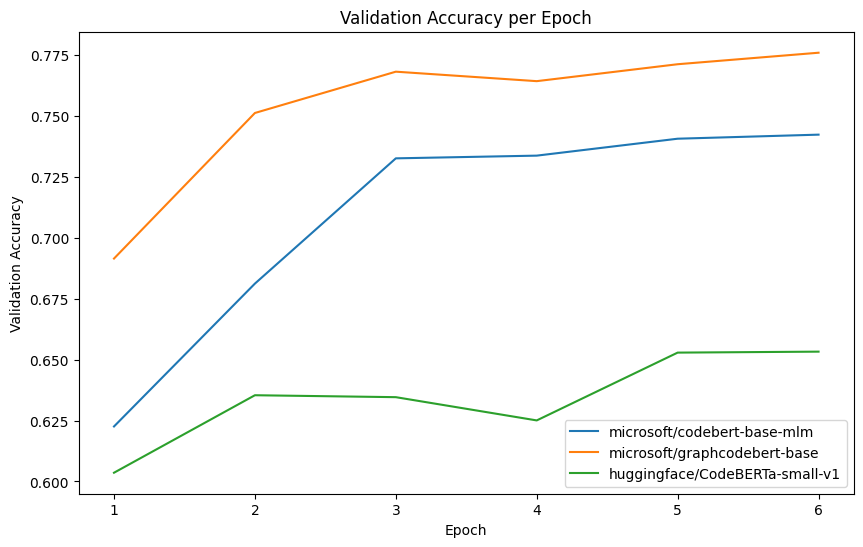

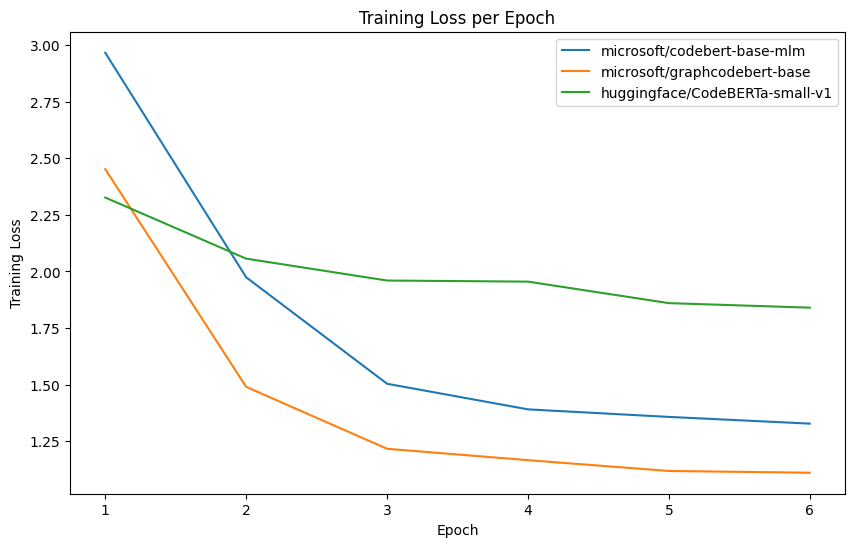

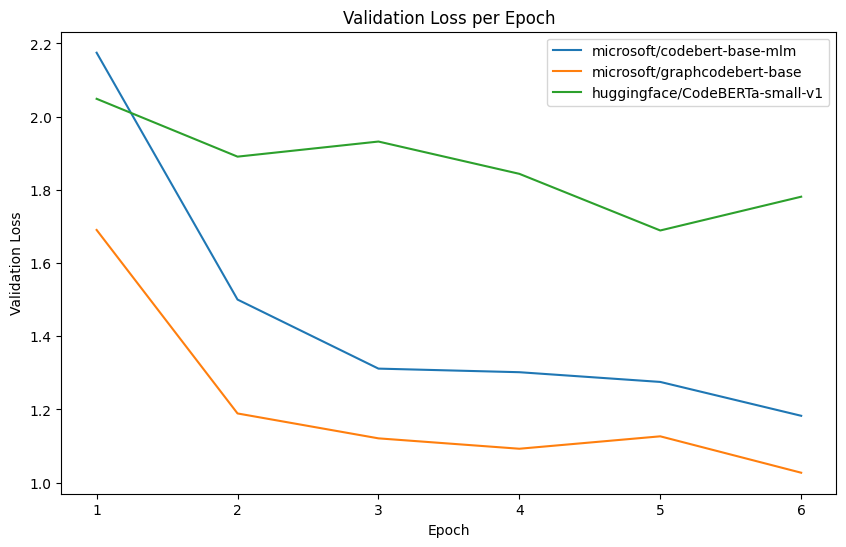

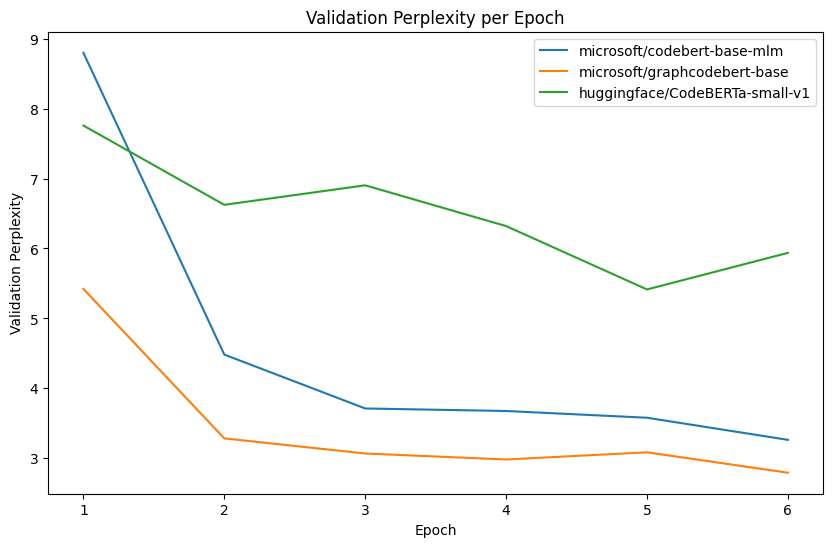

In [ ]:
# Graph model epoch vs. validation accuracy

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.xticks(range(1, max(len(hst['val_accuracy']) for hst in model_results.values()) + 1))
plt.ylabel("Validation Accuracy")

for (model_name, mask_strategy), history in model_results.items():
    if mask_strategy == 'single':
        continue
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label=f"{model_name}")

plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.xticks(range(1, max(len(hst['train_loss']) for hst in model_results.values()) + 1))
plt.ylabel("Training Loss")

for (model_name, mask_strategy), history in model_results.items():
    if mask_strategy == 'single':
        continue
    plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label=f"{model_name}")

plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.xticks(range(1, max(len(hst['val_loss']) for hst in model_results.values()) + 1))
plt.ylabel("Validation Loss")

for (model_name, mask_strategy), history in model_results.items():
    if mask_strategy == 'single':
        continue
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label=f"{model_name}")

plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Validation Perplexity per Epoch")
plt.xlabel("Epoch")
plt.xticks(range(1, max(len(hst['val_perplexity']) for hst in model_results.values()) + 1))
plt.ylabel("Validation Perplexity")

for (model_name, mask_strategy), history in model_results.items():
    if mask_strategy == 'single':
        continue
    plt.plot(range(1, len(history['val_perplexity']) + 1), history['val_perplexity'], label=f"{model_name}")

plt.legend()
plt.show()

In [ ]:
demo_prediction(str(SHARED_DRIVE / 'checkpoints.huggingface/CodeBERTa-small-v1.all/best_model'))

Original code:
def fizzbuzz(count):
    for num in range(1, count):
        if num % 3 == 0 and num % 5 == 0:
            print("FizzBuzz")
        elif num % 3 == 0:
            print("Fizz")
        elif num % 5 == 0:
            print("Buzz")
        else:
            print(num)


Masked code:
def fizzbuzz(count):
    for <mask> in range(1, <mask>):
        if <mask> % 3 == 0 and <mask> % 5 == 0:
            print('FizzBuzz')
        elif <mask> % 3 == 0:
            print('Fizz')
        elif <mask> % 5 == 0:
            print('Buzz')
        else:
            print(<mask>)

Masked identifiers: ['num', 'count']

Predicted code:
def fizzbuzz(count):
    for ii in range(1, -1):
        if (count % 3 == 0 and
i % 5 == 0:
            print('FizzBuzz')
        elif ncount % 3 == 0:
            print('Fizz')
        elif (count % 5 == 0:
            print('Buzz')
        else:
            print(count)


"def fizzbuzz(count):\n    for ii in range(1, -1):\n        if (count % 3 == 0 and\ni % 5 == 0:\n            print('FizzBuzz')\n        elif ncount % 3 == 0:\n            print('Fizz')\n        elif (count % 5 == 0:\n            print('Buzz')\n        else:\n            print(count)"

In [ ]:
### Fine-tuned model evaluation

model_paths = [
    SHARED_DRIVE / "checkpoints.microsoft" / "codebert-base-mlm.all" / "best_model",
    SHARED_DRIVE / "checkpoints.microsoft" / "codebert-base-mlm.single" / "best_model",
    SHARED_DRIVE / "checkpoints.microsoft" / "graphcodebert-base.all" / "best_model",
    SHARED_DRIVE / "checkpoints.microsoft" / "graphcodebert-base.single" / "best_model",
    SHARED_DRIVE / "checkpoints.huggingface" / "CodeBERTa-small-v1.all" / "best_model",
    SHARED_DRIVE / "checkpoints.huggingface" / "CodeBERTa-small-v1.single" / "best_model",
]

compare_models(
    dataset_name="mbpp",
    split="test",
    limit=200,
    models=list(map(str, model_paths)),
    local_data_path=SHARED_DRIVE / "mbpp.jsonl"
)


MODEL COMPARISON
Dataset: mbpp (test)
Samples: 200
Models: ['/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/best_model', '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model', '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.all/best_model', '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.single/best_model', '/content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.all/best_model', '/content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.single/best_model']

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   99.00%
  Tests Passed:   19.00%
  Exact Match:    12.50%
  Identifier Acc: 49.24%

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   99.00%
  Tests Passed:   19.00%
  Exact Match:    12.50%
  Identifier Acc: 49.24%

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.all/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   98.00%
  Tests Passed:   17.00%
  Exact Match:    12.00%
  Identifier Acc: 51.10%

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.single/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   98.00%
  Tests Passed:   17.00%
  Exact Match:    12.00%
  Identifier Acc: 51.10%

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.all/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   44.50%
  Tests Passed:   5.00%
  Exact Match:    3.50%
  Identifier Acc: 18.67%

----------------------------------------
Evaluating: /content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.single/best_model
----------------------------------------


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\*'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'
<unknown>:3: SyntaxWarning: invalid escape sequence '\W'


  Syntax Valid:   44.50%
  Tests Passed:   5.00%
  Exact Match:    3.50%
  Identifier Acc: 18.67%

COMPARISON SUMMARY

Model                         Syntax      Tests      Exact     ID Acc
-------------------------------------------------------------------
/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/best_model     99.0%     19.0%     12.5%     49.2%
/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model     99.0%     19.0%     12.5%     49.2%
/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.all/best_model     98.0%     17.0%     12.0%     51.1%
/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.single/best_model     98.0%     17.0%     12.0%     51.1%
/content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.all/best_model     44.5%      5.

{'metadata': {'dataset': 'mbpp',
  'split': 'test',
  'num_samples': 200,
  'models': ['/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/best_model',
   '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model',
   '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.all/best_model',
   '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/graphcodebert-base.single/best_model',
   '/content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.all/best_model',
   '/content/drive/Shareddrives/Natural Language Processing/checkpoints.huggingface/CodeBERTa-small-v1.single/best_model']},
 'results': {'/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.all/best_model': {'syntax_valid_rate': 0.99,
   'tests_passed_rate': 0.19,
   'exact_

In [ ]:
demo_prediction('/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model')

Original code:

def calculate_sum(numbers):
    total = 0
    for num in numbers:
        total += num
    return total


Masked code:
def calculate_sum(numbers):
    <mask> = 0
    for <mask> in <mask>:
        <mask> += <mask>
    return <mask>

Masked identifiers: ['total', 'num', 'numbers']

Predicted code:
def calculate_sum(numbers):
    sum = 0
    for number in numbers:
        sum += num
    return result


'def calculate_sum(numbers):\n    sum = 0\n    for number in numbers:\n        sum += num\n    return result'

In [ ]:
run_evaluation_pipeline(
    dataset_name="mbpp",
    split="test",
    limit=50,
    model_name="/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model",
)


EVALUATION PIPELINE

Step 1: Loading mbpp dataset...


README.md: 0.00B [00:00, ?B/s]

full/train-00000-of-00001.parquet:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

full/test-00000-of-00001.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

full/validation-00000-of-00001.parquet:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

full/prompt-00000-of-00001.parquet:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/374 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating prompt split:   0%|          | 0/10 [00:00<?, ? examples/s]

  Loaded 50 samples

Step 2: Applying masking...
  Masked 50 samples successfully

  Running oracle sanity check...
  ✓ Oracle test passed (evaluation framework working correctly)

Step 3: Running predictions with /content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model...


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'


  Progress: 50/50
  Generated 50 predictions

Step 4: Evaluating predictions...


<unknown>:3: SyntaxWarning: invalid escape sequence '\w'
<unknown>:3: SyntaxWarning: invalid escape sequence '\w'



EVALUATION SUMMARY
Total samples evaluated: 50

Metric                  Count       Rate
---------------------------------------------
Syntax Valid               48       96.00%
Tests Passed               13       26.00%
Exact Match                10       20.00%

Mean Identifier Accuracy: 48.60%


Pipeline completed in 22.70 seconds


{'metadata': {'dataset': 'mbpp',
  'split': 'test',
  'model': '/content/drive/Shareddrives/Natural Language Processing/checkpoints.microsoft/codebert-base-mlm.single/best_model',
  'num_samples': 50,
  'elapsed_time_seconds': 22.7},
 'summary': {'total_samples': 50,
  'syntax_valid': {'count': 48, 'rate': 0.96},
  'tests_passed': {'count': 13, 'rate': 0.26},
  'exact_match': {'count': 10, 'rate': 0.2},
  'mean_identifier_accuracy': 0.486,
  'errors': {'execution': 0, 'timeout': 0}},
 'detailed_results': [{'task_id': '11',
   'syntax_valid': True,
   'tests_passed': True,
   'exact_match': True,
   'identifier_accuracy': 1.0,
   'syntax_error': None,
   'tests_error': None},
  {'task_id': '12',
   'syntax_valid': True,
   'tests_passed': False,
   'exact_match': False,
   'identifier_accuracy': 0.5,
   'syntax_error': None,
   'tests_error': "Execution error: NameError: name 'matrix' is not defined"},
  {'task_id': '13',
   'syntax_valid': True,
   'tests_passed': False,
   'exact_matc